In [1]:
import cvxpy as cp
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/hardik/Desktop/Research/Adversary-CBF/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hardik/Desktop/Research/Adversary-CBF/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
17 % 2

1

In [3]:
17 != 1

True

In [4]:
a = np.array([1,2])

In [5]:
b = np.copy(a)

In [6]:
b[0] = 3

In [7]:
a

array([1, 2])

In [26]:
x = cp.Variable(1)
p = cp.Parameter(1)
quadratic = cp.square(x)
p.value = np.array([0.001])
const = [x <= 1]
const += [x >= 1 - p]
problem = cp.Problem(cp.Minimize(quadratic), const)
problem.solve(requires_grad=True)
x.value

array([0.99899998])

In [27]:
problem.backward()
print("The gradient is {}.".format(p.gradient))

The gradient is [-0.99999985].


In [18]:
p.gradient

array([-0.99999974])

In [11]:
torch.__version__

'1.12.0+cu102'

In [12]:
a = torch.tensor([[2]])

In [13]:
torch.div(a,a-1)

tensor([[2.]])

In [2]:
import gpytorch
import math

In [72]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [288]:
A = torch.tensor(np.array([1,2]))
x = torch.tensor([2,2],requires_grad=True,dtype=torch.float)

In [295]:
a = x[0] #torch.square(x[0]) * 5
b = torch.tensor([[3]],requires_grad=True,dtype=torch.float)

In [296]:
a = torch.cat((a.reshape((1,1)),b))

In [301]:
a

tensor([[2.],
        [3.]], grad_fn=<CatBackward0>)

In [305]:
x[0]

tensor(2., grad_fn=<SelectBackward0>)

In [303]:
with torch.enable_grad():
    a.sum().backward()

In [299]:
b.grad

tensor([[1.]])

In [300]:
x.grad

tensor([21.,  0.])

In [134]:
x[0].grad
preds = model(testX)
f_mean = f_preds.mean
f_covar = f_preds.covariance_matrix


In [309]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [310]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters


# Find optimal model hyperparameters
model.train()
likelihood.train()

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 30
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/30 - Loss: 0.954   lengthscale: 0.693   noise: 0.693
Iter 2/30 - Loss: 0.923   lengthscale: 0.644   noise: 0.644
Iter 3/30 - Loss: 0.888   lengthscale: 0.598   noise: 0.598
Iter 4/30 - Loss: 0.849   lengthscale: 0.555   noise: 0.554
Iter 5/30 - Loss: 0.805   lengthscale: 0.514   noise: 0.513
Iter 6/30 - Loss: 0.755   lengthscale: 0.475   noise: 0.474
Iter 7/30 - Loss: 0.700   lengthscale: 0.439   noise: 0.437
Iter 8/30 - Loss: 0.644   lengthscale: 0.405   noise: 0.402
Iter 9/30 - Loss: 0.590   lengthscale: 0.372   noise: 0.369
Iter 10/30 - Loss: 0.541   lengthscale: 0.342   noise: 0.339
Iter 11/30 - Loss: 0.497   lengthscale: 0.315   noise: 0.310
Iter 12/30 - Loss: 0.457   lengthscale: 0.291   noise: 0.283
Iter 13/30 - Loss: 0.420   lengthscale: 0.271   noise: 0.259
Iter 14/30 - Loss: 0.384   lengthscale: 0.254   noise: 0.236
Iter 15/30 - Loss: 0.349   lengthscale: 0.241   noise: 0.215
Iter 16/30 - Loss: 0.314   lengthscale: 0.230   noise: 0.196
Iter 17/30 - Loss: 0.280   length

In [311]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [312]:
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51, requires_grad=True)
    observed_pred = likelihood(model(test_x))

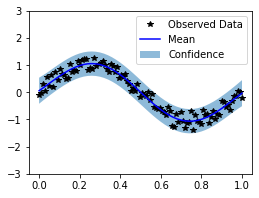

In [313]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [321]:
observed_pred.covariance_matrix[]

torch.Size([51, 51])

In [322]:
model(test_x).covariance_matrix.shape

torch.Size([51, 51])

In [316]:
likelihood(model(test_x)).mean.shape

tensor([ 0.0567,  0.1624,  0.2707,  0.3795,  0.4868,  0.5905,  0.6884,  0.7784,
         0.8585,  0.9270,  0.9820,  1.0223,  1.0468,  1.0545,  1.0451,  1.0184,
         0.9747,  0.9145,  0.8386,  0.7484,  0.6453,  0.5310,  0.4075,  0.2768,
         0.1413,  0.0033, -0.1349, -0.2709, -0.4023, -0.5270, -0.6426, -0.7474,
        -0.8394, -0.9173, -0.9796, -1.0255, -1.0542, -1.0655, -1.0592, -1.0358,
        -0.9960, -0.9407, -0.8712, -0.7892, -0.6964, -0.5949, -0.4868, -0.3743,
        -0.2596, -0.1451, -0.0327], grad_fn=<ViewBackward0>)

In [243]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x =  torch.cat ( (torch.linspace(0, 1, 100).reshape(-1,1),  torch.linspace(-0.5, 0.5, 100).reshape(-1,1)), 1 )
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x[:,0] * (2 * math.pi)) + train_x[:,1] * 3 +  torch.randn(train_x.size()[0]) * math.sqrt(0.04)

In [244]:
train_y

tensor([-1.9435e+00, -1.6642e+00, -1.3885e+00, -9.1477e-01, -8.9229e-01,
        -1.2218e+00, -9.8330e-01, -1.3705e+00, -8.0258e-01, -4.7033e-01,
        -6.1223e-01, -3.9923e-01, -6.0768e-01, -6.8359e-01, -2.5790e-02,
        -5.2378e-01, -6.0159e-02, -8.7785e-02, -1.6056e-01,  8.4152e-02,
         1.2648e-01,  1.8063e-01,  4.9475e-01,  9.3538e-02,  3.4815e-01,
         4.5323e-01,  2.5936e-01,  3.4477e-01,  3.2682e-01,  2.8664e-01,
         4.0270e-01,  5.4730e-01,  6.0069e-01,  6.0073e-01,  3.8974e-01,
         1.8194e-01,  3.0586e-01,  3.3457e-01,  3.9940e-01, -6.8730e-03,
         2.2894e-01,  1.3164e-01,  4.5387e-01,  2.6800e-01,  1.4775e-01,
         3.1796e-01,  5.7168e-04,  1.9722e-01,  4.6249e-01, -6.7449e-02,
        -1.3187e-01, -1.8685e-01, -5.4136e-01, -3.9378e-01,  2.8493e-01,
         4.6386e-02, -3.0435e-01, -1.1964e-01, -6.5248e-02, -9.7795e-02,
        -3.0824e-01, -1.4589e-01, -4.5584e-01, -1.9308e-01, -1.0430e-01,
        -3.1927e-01, -2.7763e-01, -3.8075e-03, -3.1

In [245]:
model = ExactGPModel(train_x, train_y, likelihood)

In [246]:

# Find optimal model hyperparameters
model.train()
likelihood.train()

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 30
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

Iter 1/30 - Loss: 0.396   lengthscale: 0.693   noise: 0.048
Iter 2/30 - Loss: 0.398   lengthscale: 0.693   noise: 0.045
Iter 3/30 - Loss: 0.401   lengthscale: 0.693   noise: 0.042
Iter 4/30 - Loss: 0.405   lengthscale: 0.693   noise: 0.039
Iter 5/30 - Loss: 0.410   lengthscale: 0.693   noise: 0.037
Iter 6/30 - Loss: 0.415   lengthscale: 0.693   noise: 0.036
Iter 7/30 - Loss: 0.420   lengthscale: 0.693   noise: 0.034
Iter 8/30 - Loss: 0.424   lengthscale: 0.693   noise: 0.034
Iter 9/30 - Loss: 0.427   lengthscale: 0.693   noise: 0.033
Iter 10/30 - Loss: 0.428   lengthscale: 0.693   noise: 0.033
Iter 11/30 - Loss: 0.429   lengthscale: 0.693   noise: 0.032
Iter 12/30 - Loss: 0.429   lengthscale: 0.693   noise: 0.032
Iter 13/30 - Loss: 0.427   lengthscale: 0.693   noise: 0.033
Iter 14/30 - Loss: 0.425   lengthscale: 0.693   noise: 0.033
Iter 15/30 - Loss: 0.422   lengthscale: 0.693   noise: 0.034
Iter 16/30 - Loss: 0.419   lengthscale: 0.693   noise: 0.035
Iter 17/30 - Loss: 0.416   length

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [255]:
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with gpytorch.settings.fast_pred_var():
    test_x = torch.tensor( np.append( np.linspace(0,1,51).reshape(-1,1), np.linspace(-0.5,0.5,51).reshape(-1,1) , axis=1)  , requires_grad=True, dtype=torch.float)
    observed_pred = likelihood(model(test_x))

In [248]:
test_x = torch.tensor( np.append( np.linspace(0,1,51).reshape(-1,1), np.linspace(-0.5,0.5,51).reshape(-1,1) , axis=1)  , requires_grad=True, dtype=torch.float)

In [249]:
model(train_x)

/home/hardik/Desktop/Research/Adversary-CBF/venv/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


MultivariateNormal(loc: torch.Size([100]))

In [250]:
model(test_x)

MultivariateNormal(loc: torch.Size([51]))

In [252]:
observed_pred = likelihood(model(test_x))

In [257]:
observed_pred.mean

tensor([-1.3744, -1.2036, -1.0377, -0.8780, -0.7257, -0.5818, -0.4473, -0.3231,
        -0.2098, -0.1082, -0.0186,  0.0588,  0.1236,  0.1761,  0.2163,  0.2447,
         0.2618,  0.2681,  0.2645,  0.2520,  0.2315,  0.2042,  0.1714,  0.1343,
         0.0943,  0.0528,  0.0112, -0.0292, -0.0670, -0.1008, -0.1293, -0.1515,
        -0.1662, -0.1724, -0.1694, -0.1563, -0.1325, -0.0978, -0.0517,  0.0059,
         0.0749,  0.1551,  0.2462,  0.3477,  0.4591,  0.5795,  0.7082,  0.8441,
         0.9862,  1.1335,  1.2847], grad_fn=<ViewBackward0>)

In [260]:
observed_pred.mean[0].sum().backward()

In [338]:
# test_x.grad

In [270]:
a = []
a = np.append(a,np.array([1,2]).reshape(-1,1), axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [269]:
a

array([1., 2.])

In [271]:
a = np.append( np.ones((2,2)), np.zeros((2,2)), axis=1 )

In [277]:
a[0,-6:]

array([1., 1., 0., 0.])

In [274]:
a[0,:]

array([1., 1., 0., 0.])

In [282]:
for i in range(1,5):
    print(i)

1
2
3
4


In [285]:
a = 3
type(a)==int

True

In [287]:
b = 'hello'
type(b)==str

True

In [2]:
# To avoid copying things to GPU memory,
# ideally allocate everything in torch on the GPU
# and avoid non-torch function calls
import torch
from torchquad import MonteCarlo, set_up_backend

#export CUDA_VISIBLE_DEVICES=""
# Enable GPU support if available and set the floating point precision
# set_up_backend("torch", data_type="float32")

# The function we want to integrate, in this example
# f(x0,x1) = sin(x0) + e^x1 for x0=[0,1] and x1=[-1,1]
# Note that the function needs to support multiple evaluations at once (first
# dimension of x here)
# Expected result here is ~3.2698
def some_function(x):
    return torch.sin(x[:, 0]) + torch.exp(x[:, 1])

# Declare an integrator;
# here we use the simple, stochastic Monte Carlo integration method
mc = MonteCarlo()

# Compute the function integral by sampling 10000 points over domain
integral_value = mc.integrate(
    some_function,
    dim=2,
    N=10000,
    integration_domain=[[0, 1], [-1, 1]],
    backend="torch",
)

### Multivariate GP

In [4]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate Training Data

In [10]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

### MultiVariate GPP class

In [11]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

### Train Hyperparameters

In [12]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()


Iter 1/50 - Loss: 1.205
Iter 2/50 - Loss: 1.167
Iter 3/50 - Loss: 1.130
Iter 4/50 - Loss: 1.092
Iter 5/50 - Loss: 1.055
Iter 6/50 - Loss: 1.016
Iter 7/50 - Loss: 0.976
Iter 8/50 - Loss: 0.936
Iter 9/50 - Loss: 0.896
Iter 10/50 - Loss: 0.856
Iter 11/50 - Loss: 0.817
Iter 12/50 - Loss: 0.779
Iter 13/50 - Loss: 0.741
Iter 14/50 - Loss: 0.702
Iter 15/50 - Loss: 0.663
Iter 16/50 - Loss: 0.623
Iter 17/50 - Loss: 0.582
Iter 18/50 - Loss: 0.541
Iter 19/50 - Loss: 0.500
Iter 20/50 - Loss: 0.459
Iter 21/50 - Loss: 0.420
Iter 22/50 - Loss: 0.381
Iter 23/50 - Loss: 0.344
Iter 24/50 - Loss: 0.309
Iter 25/50 - Loss: 0.274
Iter 26/50 - Loss: 0.240
Iter 27/50 - Loss: 0.207
Iter 28/50 - Loss: 0.175
Iter 29/50 - Loss: 0.145
Iter 30/50 - Loss: 0.118
Iter 31/50 - Loss: 0.093
Iter 32/50 - Loss: 0.070
Iter 33/50 - Loss: 0.050
Iter 34/50 - Loss: 0.032
Iter 35/50 - Loss: 0.017
Iter 36/50 - Loss: 0.004
Iter 37/50 - Loss: -0.007
Iter 38/50 - Loss: -0.015
Iter 39/50 - Loss: -0.021
Iter 40/50 - Loss: -0.024
Iter 

### Make predictions

Text(0.5, 1.0, 'Observed Values (Likelihood)')

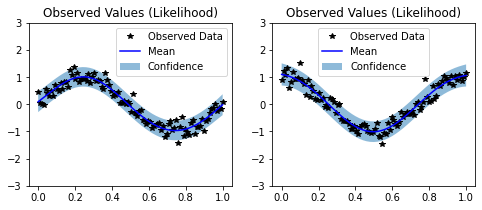

In [14]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')
